This notebook demonstrates inverse kinematics of manipulator using TTGO.

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/
    Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')

from planar_manipulator import PlanarManipulator
from cost_utils import PlanarManipulatorCost
from plot_utils import plot_chain
from utils import test_ttgo
from ttgo import TTGO
import time
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

Define the robot paramters

In [2]:
n_joints = 3 # number of links
link_lengths = torch.tensor([1.4/n_joints]*n_joints)
max_theta = np.pi/1.1 # joint angle limits
min_theta = -1*max_theta
# define the robot
robot = PlanarManipulator(n_joints=n_joints,link_lengths=link_lengths,max_theta=max_theta,n_kp=5, device='cpu')

Define the cost and the pdf

In [3]:
x_obst = [torch.tensor([0.5,0.5]),torch.tensor([-0.35,0.]),
          torch.tensor([-0.25,0.75]),torch.tensor([0,-0.75])]
r_obst = [0.25,0.15,0.25,0.3]
margin=0.025 # margin for collision avoidance
w_goal= 0.5; w_obst=0.5; # weights for each sub-cost
b_goal=0.15; b_obst=0.5 # nominal costs
costPlanarManipulator = PlanarManipulatorCost(robot,x_obst=x_obst,r_obst=r_obst, margin=margin, 
                                              w_goal=w_goal, w_obst=w_obst,
                                              b_goal=b_goal, b_obst=b_obst)
def cost(x):
    return costPlanarManipulator.cost_ik(x)[:,0]

def pdf(x):
    return torch.exp(-cost(x)**2) 

Discretization of the domain

In [4]:
# Define the range of target poses of the end-effector
pose_max = torch.sum(link_lengths)
pose_min = -1*pose_max

# Discretize the domain
d0_x = 100
d0_theta = 100
domain_task=  [torch.linspace(pose_min,pose_max,d0_x)]*2 # position of ee
domain_decision = [torch.linspace(min_theta,max_theta,d0_theta)]*n_joints # joint angles
domain =  domain_task + domain_decision 


### Fit TT-Model for the PMF

In [5]:
ttgo = TTGO(domain=domain,pdf=pdf, cost=cost)

In [6]:
ttgo.cross_approximate(rmax=100, nswp=10, eps=1e-6,kickrank=5)

cross device is cpu
Cross-approximation over a 5D domain containing 1e+10 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0  | tt-new-norm/tt-old-norm: 3.757e-03 | time:   0.0242 | largest rank:   1
iter: 1  | tt-new-norm/tt-old-norm: 6.409e+00 | time:   0.2357 | largest rank:   6
iter: 2  | tt-new-norm/tt-old-norm: 1.447e+00 | time:   0.8523 | largest rank:  11
iter: 3  | tt-new-norm/tt-old-norm: 1.152e+00 | time:   2.2038 | largest rank:  16
iter: 4  | tt-new-norm/tt-old-norm: 1.343e+00 | time:   4.5092 | largest rank:  21
iter: 5  | tt-new-norm/tt-old-norm: 1.185e+00 | time:   8.2126 | largest rank:  26
iter: 6  | tt-new-norm/tt-old-norm: 1.130e+00 | time:  13.4525 | largest rank:  31
iter: 7  | tt-new-norm/tt-old-norm: 1.054e+00 | time:  20.8146 | largest rank:  36
iter: 8  | tt-new-norm/tt-old-norm: 1.043e+00 | time:  29.5401 | largest rank: 

### Test the model

In [7]:
# Generate test set (feasible target points)
ns = 1000
test_theta = torch.zeros(ns,n_joints)
for i in range(n_joints):
    unif = torch.distributions.uniform.Uniform(low=min_theta,high=max_theta)
    sample = torch.tensor([unif.sample() for i in range(ns)])
    test_theta[:,i] = sample
    
_, _, test_x, test_orient = robot.forward_kin(test_theta)

test_set = torch.cat((test_x,test_theta),dim=-1)
cost_values = cost(test_set)
test_set = test_set[cost(test_set)<0.1]
ns = min(test_set.shape[0],50)
test_task = test_set[:ns,:len(domain_task)]


In [8]:
# # # Save the model
# file_name = 'planar_ik_.pickle'
# torch.save({
#     'tt_model':ttgo.tt_model,
#     'w': (w_goal,w_obst),
#     'b': (b_goal,b_obst),
#     'd0':(d0_x,d0_theta),
#     'margin': margin,
#     'domain': domain,
#     'test_task': test_task,
#     'x_obst':x_obst,
#     'r_obst':r_obst,
#     'n_joints':n_joints,
#     'link_lengths':link_lengths
#     }, file_name)


In [9]:
sites_task = [0,1]
ttgo.set_sites(sites_task)


In [10]:
n_samples_tt = 20
alpha = 0.9
norm=1
print("total-cost | dist-to-goal | num-of-collisions ")
_ = test_ttgo(ttgo=ttgo.clone(), cost= costPlanarManipulator.cost_ik, test_task=test_task, 
          n_samples_tt=n_samples_tt,alpha=alpha, norm=norm, device='cpu', test_rand=True)


total-cost | dist-to-goal | num-of-collisions 
################################################################
################################################################
norm:1  |  alpha:0.9  |  n_samples_tt:20  |  n_samples_rand:20 | 
################################################################
################################################################
Cost TT (raw)           :  tensor([0.19, 0.05, 0.01])
Cost TT (optimized)     :  tensor([0.03, 0.01, 0.00])
Cost rand (raw)           :  tensor([1.35, 0.35, 0.16])
Cost rand (optimized)     :  tensor([0.17, 0.05, 0.01])
-------------------------------------
Performance, c_total <  0.33  (intersection)
-------------------------------------
Success-rate (tt vs rand) :  0.98 0.88
# iterations (tt vs rand) :  6.744186046511628 9.86046511627907
Cost-mean-tt-raw: tensor([0.18, 0.05, 0.01])
Cost-mean-tt-opt: tensor([0.01, 0.00, 0.00])
Cost-mean-rand-raw: tensor([1.23, 0.32, 0.16])
Cost-mean-rand-opt: tensor([0.02, 0.01, 0.00])

### Visualization

In [11]:
# choose a task-parameter (target position of end-effector)
s = np.random.choice(np.arange(ns))
x_task = test_task[s]

# Sample from TT-model
alpha=0.8
n_samples = 50
t1 = time.time()
samples, samples_idx = ttgo.sample(n_samples=n_samples, x_task=x_task, alpha=alpha, norm=1) 

# Fine tune the approximation
best_estimate_tt = ttgo.choose_best_sample(samples)
best_estimate_tt_opt = ttgo.optimize(best_estimate_tt)
t2 = time.time()

# For multiple solutions
k = 5
top_k_estimate_tt = ttgo.choose_top_k_sample(samples,k)
top_k_estimate_tt_opt = 1*top_k_estimate_tt
for i in range(top_k_estimate_tt.shape[0]):
    top_k_estimate_tt_opt[i], _ = ttgo.optimize(top_k_estimate_tt[i])



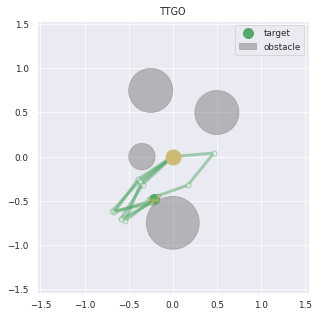

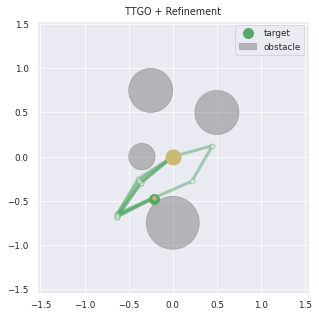

In [12]:

figsize=5    
    
_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt[:,len(sites_task):])
joint_loc = joint_loc.numpy()
link = link_lengths.numpy()
x_obst_np = [x.numpy() for x in x_obst]
x_target = [x_task[:2].numpy()]

title="TTGO"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1,figsize=figsize, title=title, 
           color_intensity=0.9, motion=False, alpha=0.5, contrast=0.3,lw=3)


_,joint_loc,_,_ = robot.forward_kin(top_k_estimate_tt_opt[:,len(sites_task):])
joint_loc = joint_loc.numpy()
link = link_lengths.numpy()
x_obst_np = [x.numpy() for x in x_obst]

title = "TTGO + Refinement"
plt = plot_chain(joint_loc=joint_loc, link_lengths=link, x_obst=x_obst_np, r_obst=r_obst, 
           x_target=x_target, batch=True, skip_frame=1, figsize=figsize, title=title, 
           color_intensity=0., motion=False, alpha=0.5, contrast=0., task='ik',lw=3)